# Optimized compilation pipeline
<p>
<font size=4 color="#0f62fe">IBM Quantum Enabling Technologies Team</font>
<p>

One of the main pain points in executing circuits on IBM Quantum hardware is finding the best qubit mapping. For a given circuit, one typically tries to pick the best `initial_layout` for a given target system, and then SWAP maps using that set of qubits as the starting point. However there are a couple of issues with that execution model. First, an `initial_layout` selected, for example with respect to the noise characteristics of the system, need not be optimal for the SWAP mapping. In practice this leads to either low-noise layouts with extra SWAP gates inserted in the circuit, or optimally SWAP mapped circuits on (possibly) lousy qubits. This problem becomes more pronounced as the number of available qubits grows.  Second, there is no way to know if the system you targeted in the compilation is actually the best one to execute the compiled circuit on. With 20+ IBM Quantum systems, it is hard to determine which device is actually ideal for a given problem.

In what follows we will explain a circuit compilation pipeline that has proven to yield dramatic performance improvements, as measured by benchmarking frameworks such as the [QED-C benchmark suite](https://github.com/SRI-International/QC-App-Oriented-Benchmarks), pictured below

<img src="imgs/qedc_benchmarks.png"/>


## Frontmatter

This notebook requires the following:

- Qiskit version 0.20 or greater (`pip install -U qiskit`).

- Mapomatic (`pip install mapomatic`)

- M3 (`pip install mthree`)

In [9]:
import numpy as np
from qiskit import *
from qiskit.quantum_info import hellinger_fidelity

# Mapomatic for qubit selection
import mapomatic as mm

# mthree for measurement error mitigation and expectation values
import mthree

#Dynamical Decoupling specific modules
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import PadDynamicalDecoupling, ALAPScheduleAnalysis

import matplotlib.pyplot as plt

Load IBM Quantum account and select a backend

In [10]:
IBMQ.load_account();

ibmqfactory.load_account:WARNING:2022-04-04 21:50:27,253: Credentials are already in use. The existing account in the session will be replaced.


In [11]:
provider = IBMQ.get_provider(group='deployed')

In [12]:
backend = provider.backend.ibm_hanoi

Here we will load an interactive plot of the backend noise properties:

In [6]:
try:
    from kaleidoscope.qiskit import system_error_map
except:
    pass
else:
    display(system_error_map(backend))

## Qiskit transpiler refresher

Recall that the optimal circuit transpilation pipeline in Qiskit is `optimization_level=3` selects a good candidate `initial_layout` and SWAP mapping using the Sabre layout and routing method (arXiv:1809.02573), and performs the most 1Q and 2Q gate optimizations.  Because this method is stochastic, finding a good candidate SWAP mapping can involve mapping the circuit several times and selecting the one with the fewest entangling gates (lowest depth).

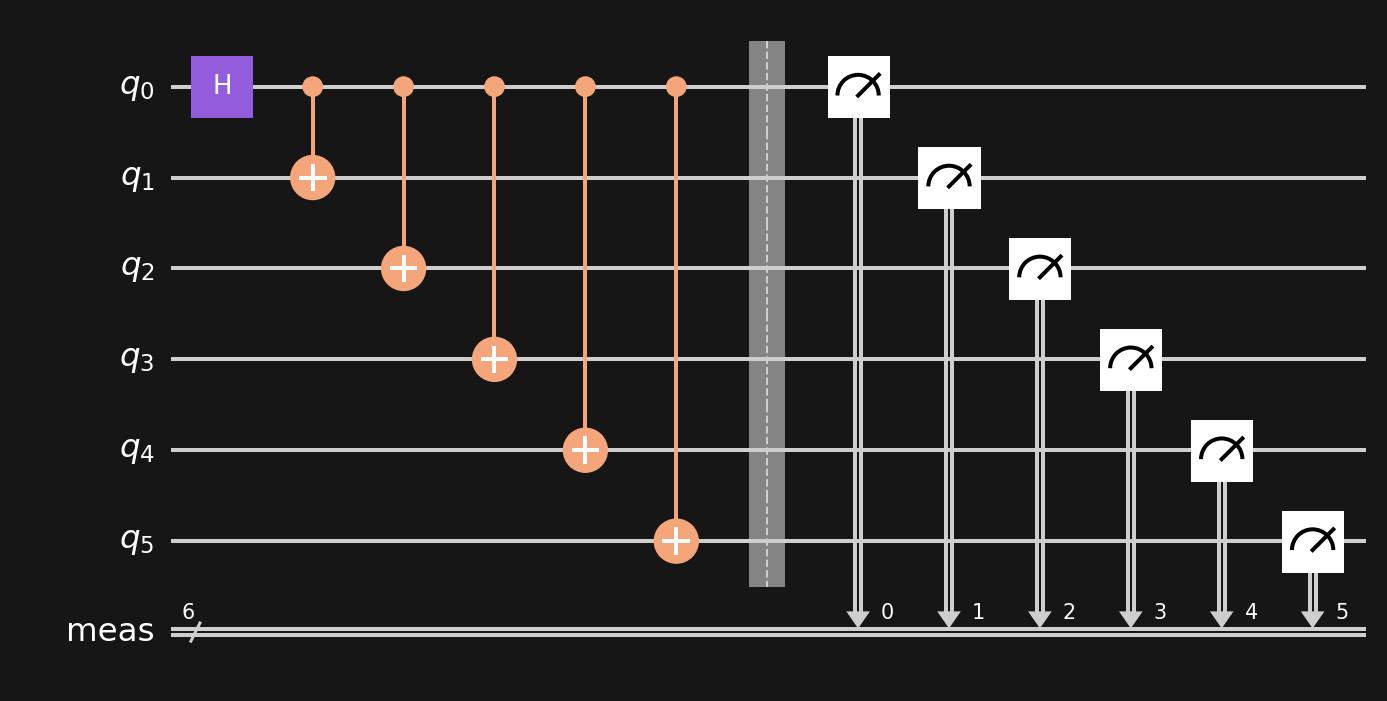

In [13]:
circ = QuantumCircuit(6)
circ.h(0)
circ.cx(0, range(1, 6))
circ.measure_all()

circ.draw('mpl')

In [14]:
trans_circs = transpile([circ]*20, backend,
                     basis_gates=backend.configuration().basis_gates+['swap'],
                     optimization_level=3,
                     seed_transpiler=[kk for kk in range(20)])

In [15]:
swap_count = np.array([circ.count_ops()['swap'] for circ in trans_circs])
print(swap_count)
best_idx = np.where(swap_count == min(swap_count))[0][0]
trans_qc = transpile(trans_circs[best_idx], backend, optimization_level=3)

[2 5 3 2 4 3 2 3 2 4 4 3 4 2 3 3 2 2 2 3]


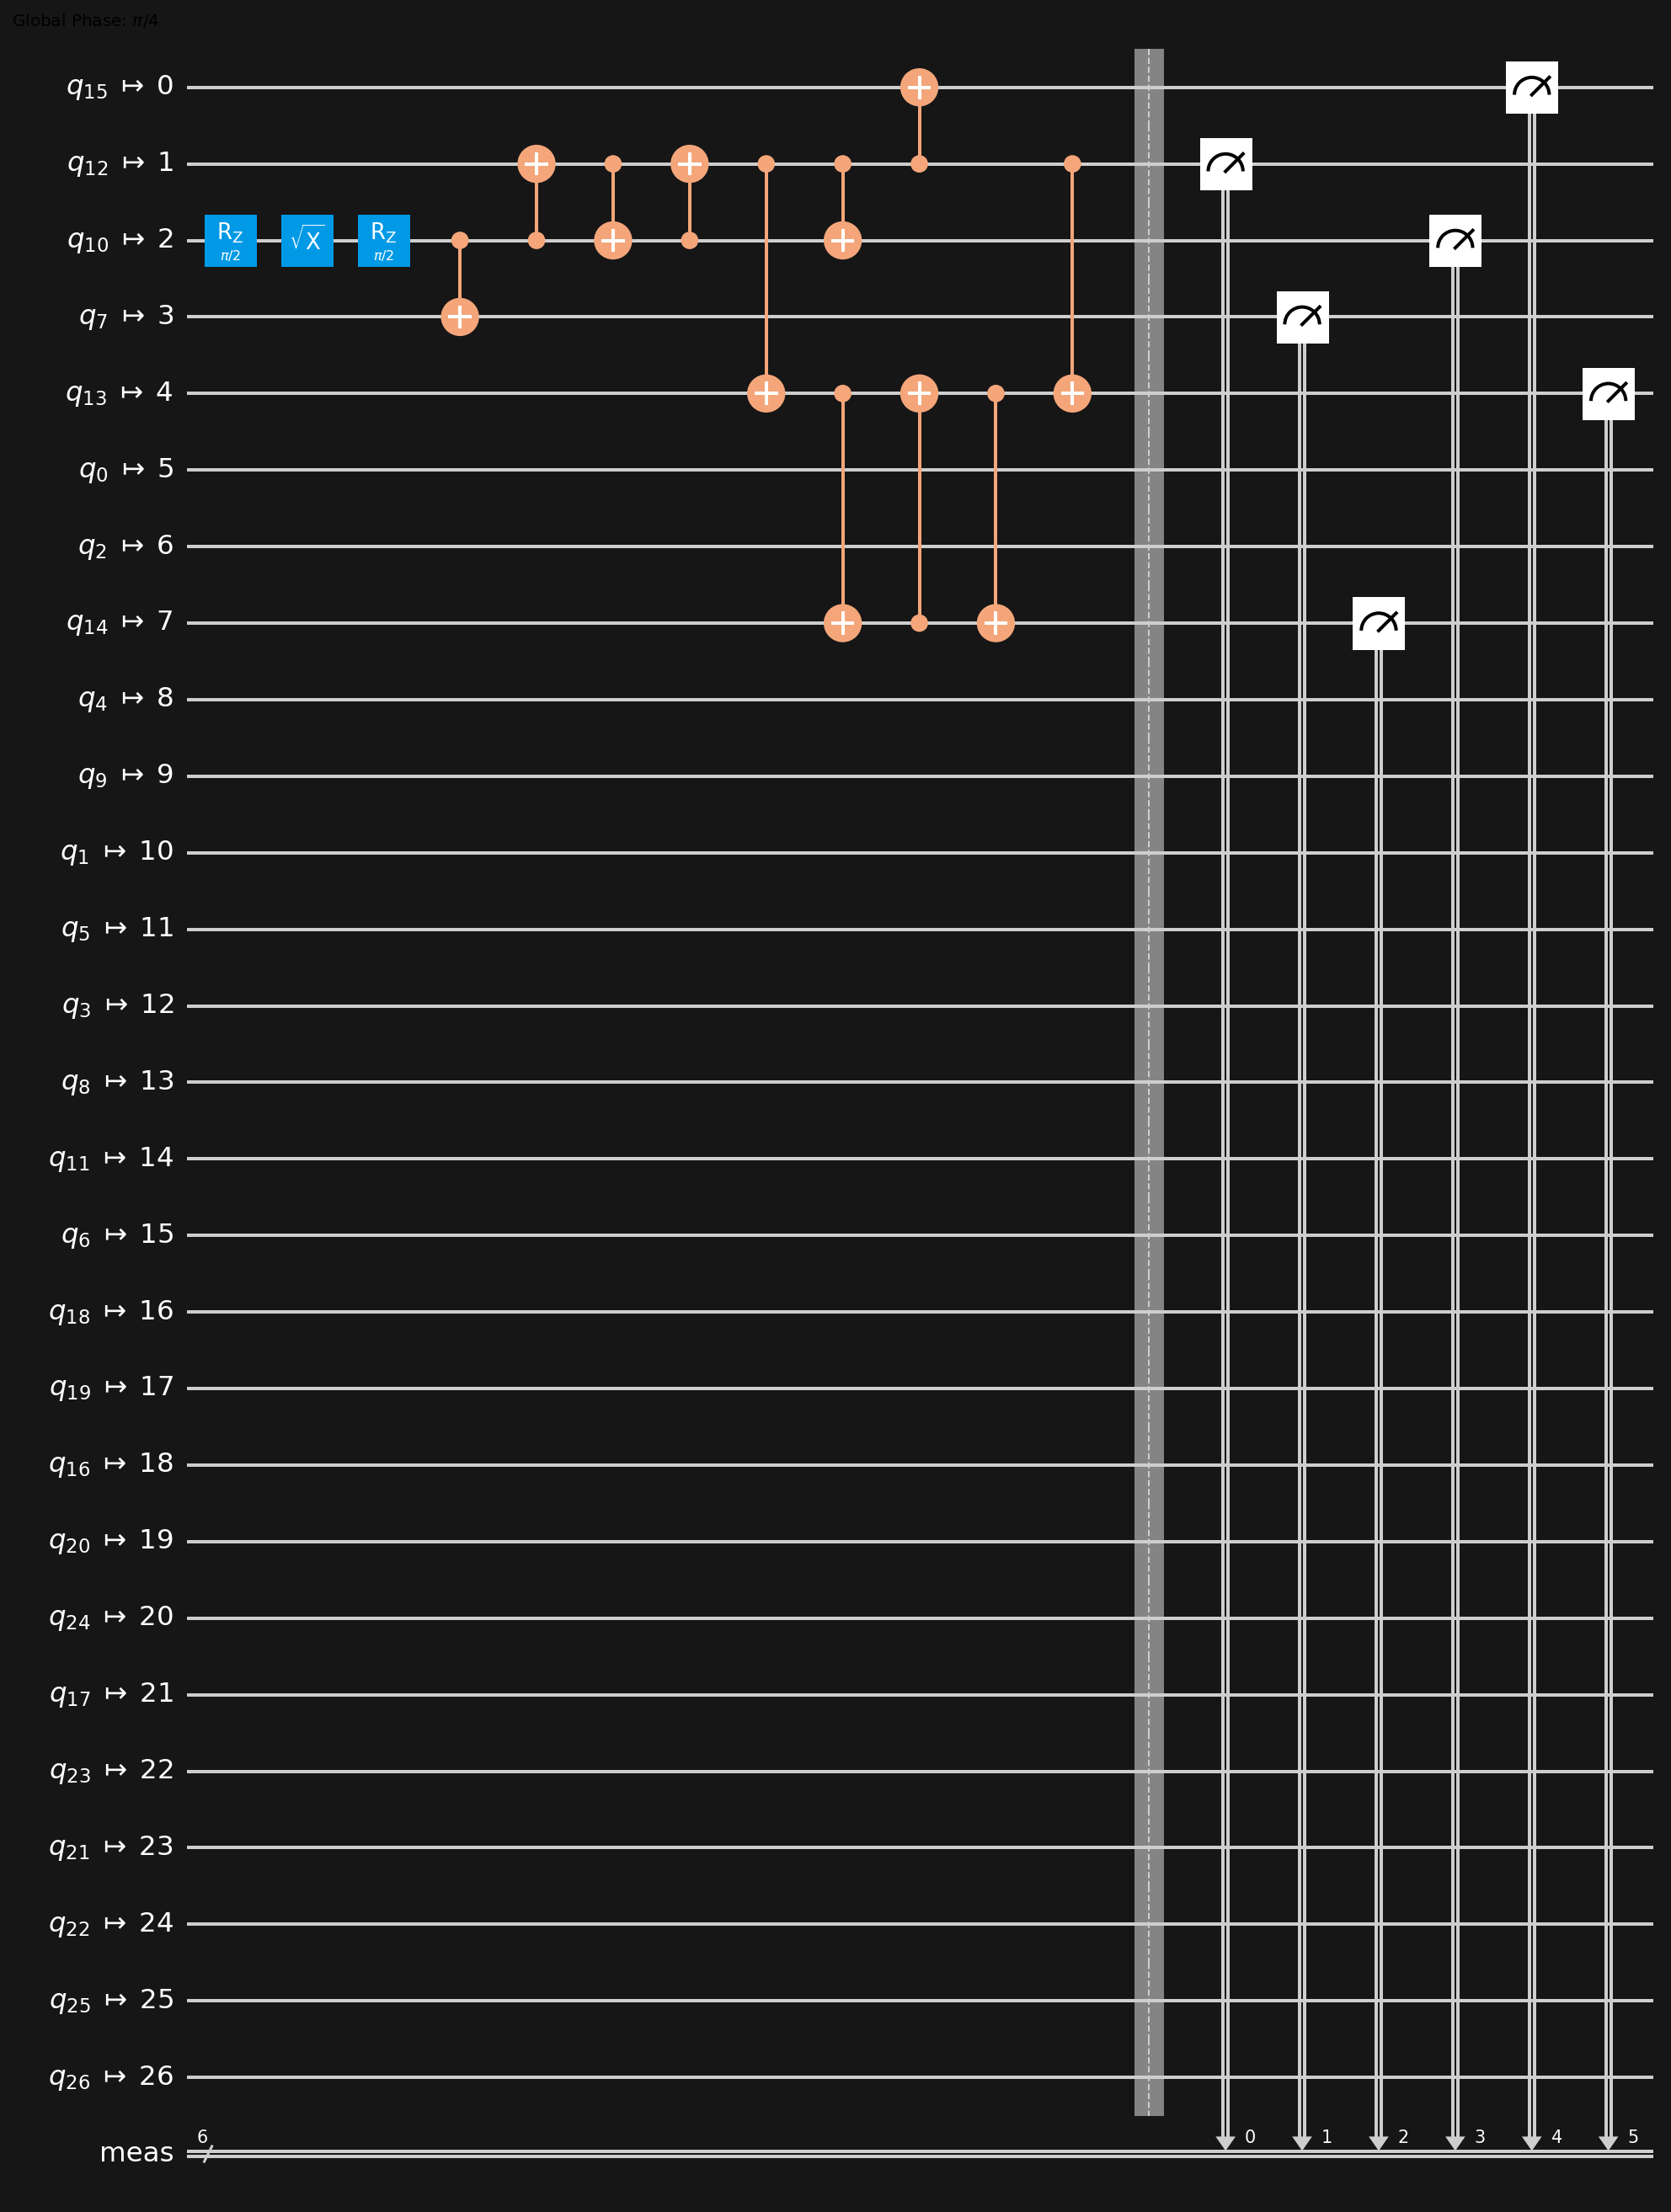

In [16]:
trans_qc.draw('mpl')

While the above recipe gives a very good swap mapping, it is insensitive to the noise properties of the gates and qubits onto which it maps.  That is to say that often one has a close to ideal SWAP mapping on less than ideal qubits.  For specific instances of a given problem it is often possible to hand-map onto a good selection of qubits.  However for larger problems, or more complex circuits this becomes difficult and automated tools are needed to find an optimal set of qubits to use.  This set of qubits also need not be on the originally targeted system.

## Mapomatic

Mapomatic is a post-compilation routine that finds the best low noise sub-graph on which to run a circuit given one or more quantum systems as target devices. Once compiled, a circuit has been rewritten so that its two-qubit gate structure matches that of a given sub-graph on the target system. mapomatic then searches for matching sub-graphs using the VF2 mapper in retworkx, and uses a heuristic to rank them based on error rates determined by the current calibration data. That is to say that given a single target system, mapomatic will return the best set of qubits on which to execute the compiled circuit. Or, given a list of systems, it will find the best system and set of qubits on which to run your circuit. Given the current size of quantum hardware, and the excellent performance of the VF2 mapper, this whole process is actually very fast.

### Deflating the circuit

When mapping a quantum circuit to a specific system the Qiskit transpiler will automatically expand the input circuit to the full size of the target device.  In order to find a good subset of qubits we must first "deflate" the circuit, and return a circuit that operates only on the active qubits in the full circuit.

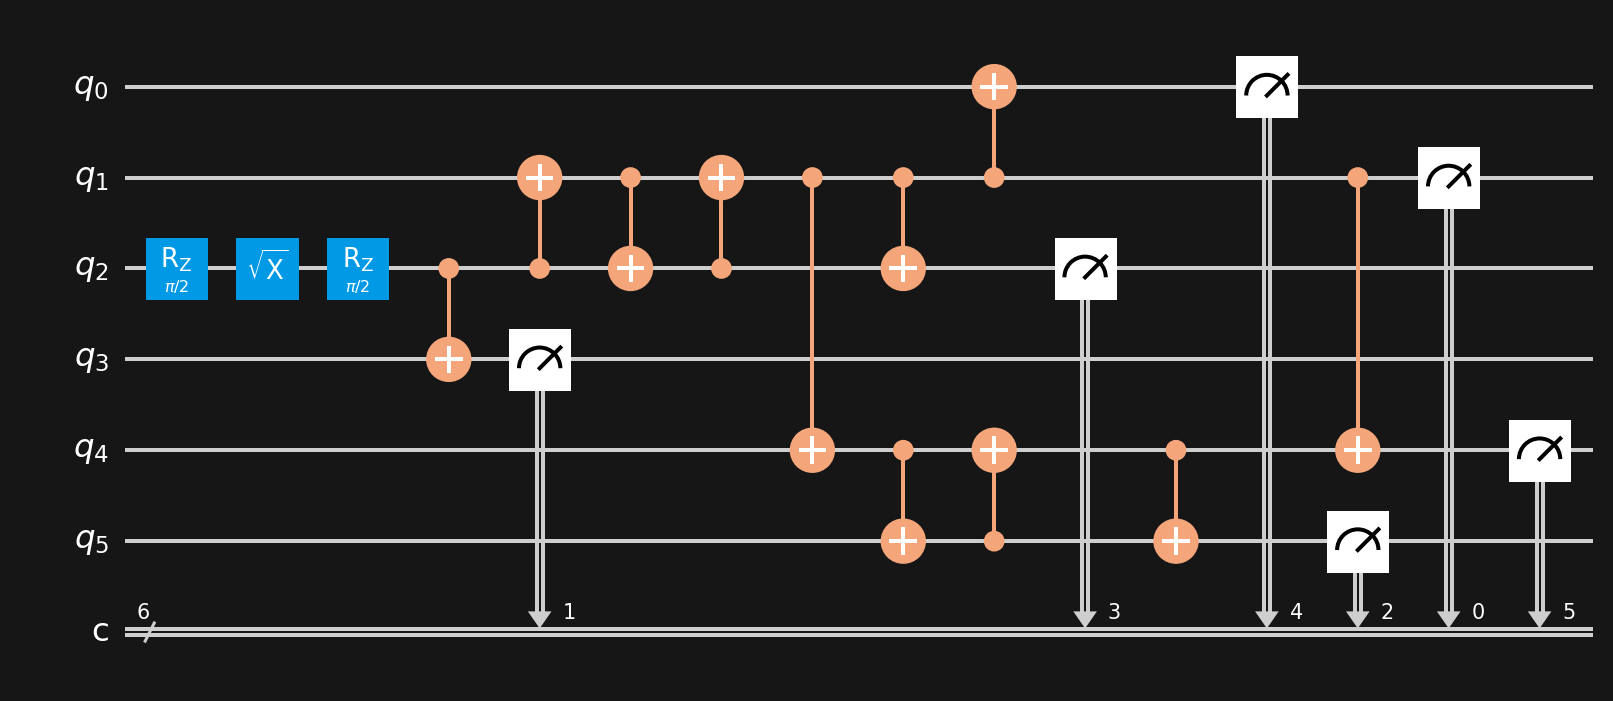

In [17]:
small_circ = mm.deflate_circuit(trans_qc)
small_circ.draw('mpl')

### Find matching layouts

Next we need to find all the possible combinations of qubits onto which this deflated circuit can be mapped.

In [18]:
layouts = mm.matching_layouts(small_circ, backend)

In [19]:
layouts

[[0, 1, 2, 3, 4, 7],
 [0, 1, 4, 7, 2, 3],
 [6, 7, 4, 1, 10, 12],
 [6, 7, 10, 12, 4, 1],
 [9, 8, 5, 3, 11, 14],
 [9, 8, 11, 14, 5, 3],
 [15, 12, 10, 7, 13, 14],
 [13, 12, 10, 7, 15, 18],
 [15, 12, 13, 14, 10, 7],
 [10, 12, 13, 14, 15, 18],
 [13, 12, 15, 18, 10, 7],
 [10, 12, 15, 18, 13, 14],
 [16, 14, 11, 8, 13, 12],
 [13, 14, 11, 8, 16, 19],
 [16, 14, 13, 12, 11, 8],
 [11, 14, 13, 12, 16, 19],
 [13, 14, 16, 19, 11, 8],
 [11, 14, 16, 19, 13, 12],
 [17, 18, 15, 12, 21, 23],
 [17, 18, 21, 23, 15, 12],
 [20, 19, 16, 14, 22, 25],
 [20, 19, 22, 25, 16, 14],
 [26, 25, 22, 19, 24, 23],
 [26, 25, 24, 23, 22, 19]]

### Scoring the layouts

Now that we have all the possible layouts, we can use the calibration data from the backend to assign a "score" to each based on the returned error rates.  By default this is just the product of all of the fidelities of the gates and measurements in the circuit.  A value close to `1.0` indicates that your circuit is likely not to yield good results.

In [20]:
scores = mm.evaluate_layouts(small_circ, layouts, backend)
scores

[([0, 1, 2, 3, 4, 7], 0.13246820999994424),
 ([0, 1, 4, 7, 2, 3], 0.13662510916515058),
 ([13, 14, 11, 8, 16, 19], 0.15424529012926202),
 ([20, 19, 16, 14, 22, 25], 0.15744491046952258),
 ([13, 14, 16, 19, 11, 8], 0.16777741956075587),
 ([20, 19, 22, 25, 16, 14], 0.1762920322455308),
 ([16, 14, 13, 12, 11, 8], 0.17750382009162669),
 ([16, 14, 11, 8, 13, 12], 0.1838439535353743),
 ([6, 7, 4, 1, 10, 12], 0.18664913344292322),
 ([6, 7, 10, 12, 4, 1], 0.1877331226095066),
 ([26, 25, 24, 23, 22, 19], 0.18843887871721987),
 ([11, 14, 13, 12, 16, 19], 0.19544548798155736),
 ([17, 18, 21, 23, 15, 12], 0.20441209585637865),
 ([15, 12, 10, 7, 13, 14], 0.2069778344892843),
 ([26, 25, 22, 19, 24, 23], 0.20806855312252903),
 ([17, 18, 15, 12, 21, 23], 0.2141512076039237),
 ([15, 12, 13, 14, 10, 7], 0.21421256475393935),
 ([11, 14, 16, 19, 13, 12], 0.2144210137139727),
 ([10, 12, 15, 18, 13, 14], 0.21545540742764113),
 ([13, 12, 10, 7, 15, 18], 0.21570747626804487),
 ([10, 12, 13, 14, 15, 18], 0.215

### Transpile to qubits with the best score

The scores are ranked from best to worst, so selecting the first set should give best results

In [21]:
best_trans_qc = transpile(small_circ, backend, initial_layout=scores[0][0])

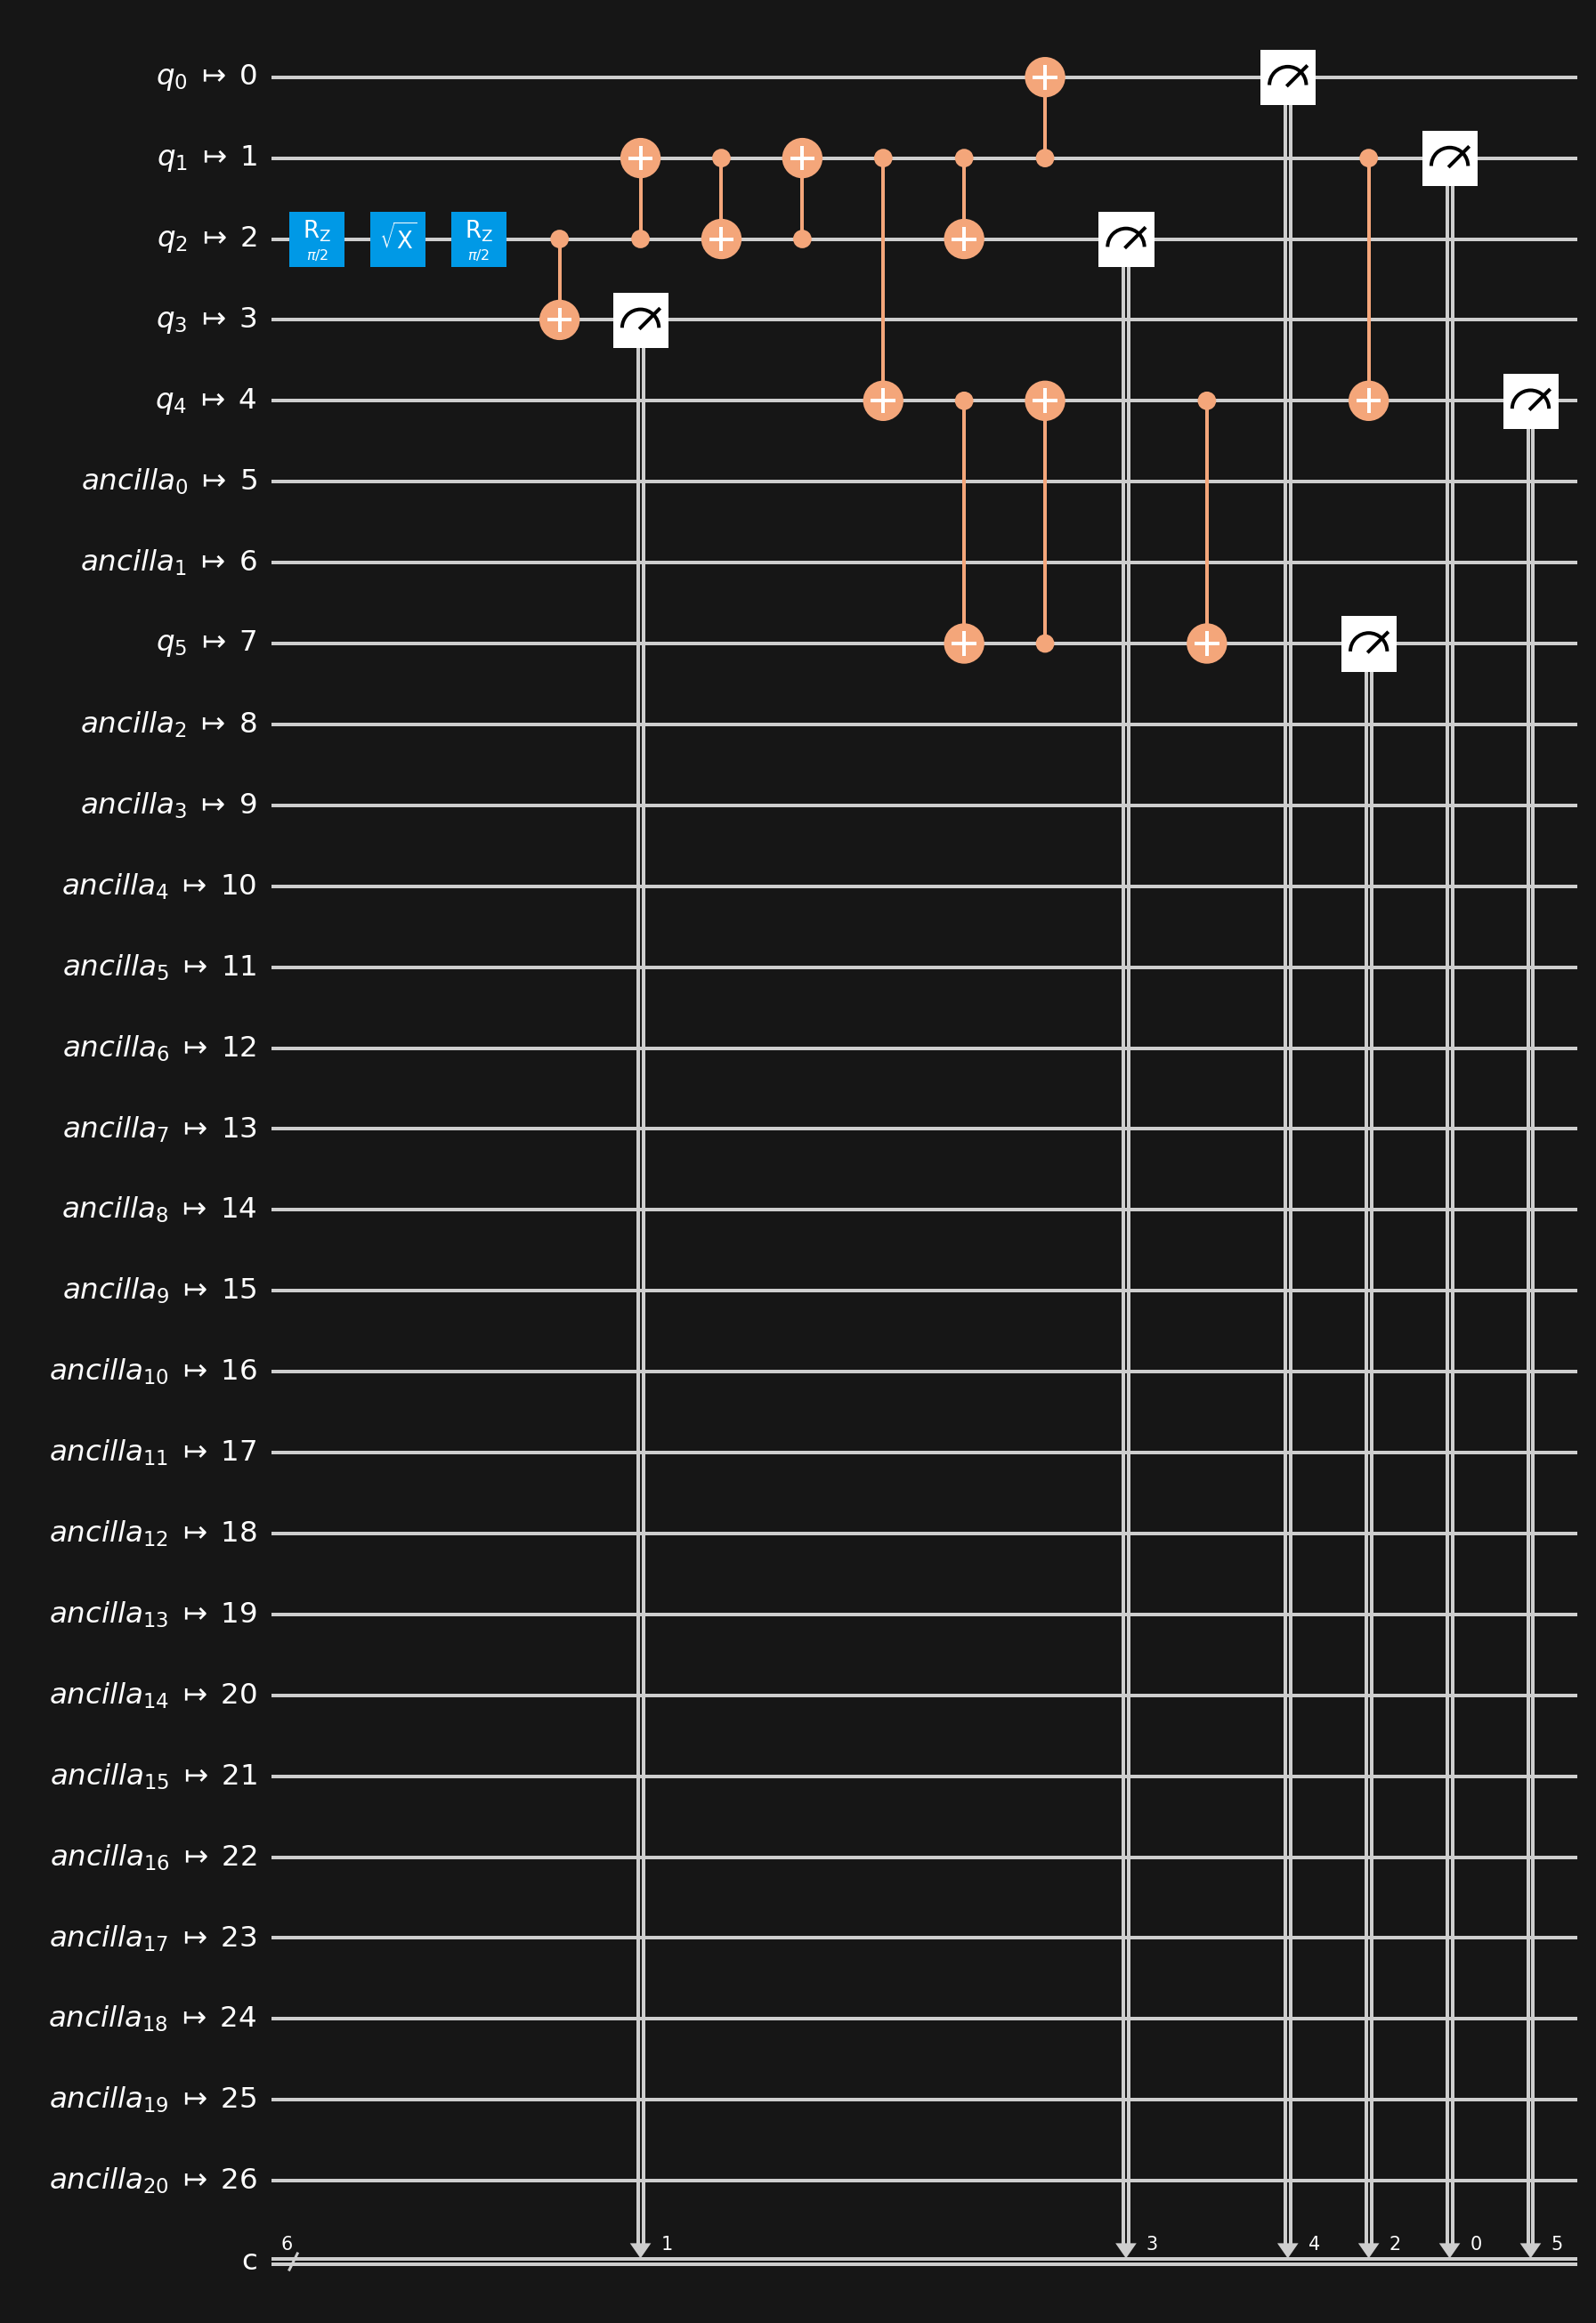

In [22]:
best_trans_qc.draw('mpl')

Let us also transpile against a bad set (here selected to avoid one of the `1.0` sets)

In [21]:
bad_trans_qc = transpile(small_circ, backend, initial_layout=scores[-3][0])

Execute both best and bad sets and see which one gives the best fidelity.

In [22]:
job = backend.run([best_trans_qc, bad_trans_qc], shots=10000)

In [28]:
target_dist = {'0'*6: 0.5, '1'*6: 0.5}

In [24]:
best_counts, bad_counts = job.result().get_counts()

In [25]:
hellinger_fidelity(best_counts, target_dist)

0.8339049639776354

In [26]:
hellinger_fidelity(bad_counts, target_dist)

0.7199522404605905

We see that our fidelity is over 10% better when using the best set verses a bad set.

## Mapomatic on several backends

We have seen how to get a good layout on a single backend, but is that backend the one optimal on which to run in the first place?  We can request Mapomatic to look over all backends that we have access to in order to identify the best one for the circuit in question.  The backends do not have to be of the same processor type, and need only be able to support the necessary entangling gate connectivity.

In [27]:
mm.best_overall_layout(small_circ, provider.backends(), successors=True)

[([3, 5, 9, 8, 11, 14], 'ibm_auckland', 0.11638943265614354),
 ([7, 4, 0, 1, 2, 3], 'ibm_hanoi', 0.13246820999994424),
 ([51, 50, 55, 49, 48, 47], 'ibm_washington', 0.1335889121454673),
 ([12, 15, 17, 18, 21, 23], 'ibm_cairo', 0.13742676931505415),
 ([14, 16, 20, 19, 22, 25], 'ibmq_montreal', 0.1457445884089067),
 ([7, 10, 15, 12, 13, 14], 'ibmq_guadalupe', 0.18135546089661103),
 ([6, 5, 3, 4, 11, 17], 'ibmq_brooklyn', 0.193372159486484),
 ([14, 16, 20, 19, 22, 25], 'ibmq_mumbai', 0.21545223260981106),
 ([14, 16, 20, 19, 22, 25], 'ibmq_toronto', 0.3073623988555444)]

We see that our original choice of backend is not the best here, and the order may yield some surprising results.

## Adding dynamical decoupling (DD)

Having found the best qubits for our circuit, we can now go and add backend and qubit specific timing information and instructions.  In order to do DD our a backend we need the following:

- The durations of each of the instructions supported by the backend

- The gates for our DD sequence, and possible spacings

- The pulse alignment supported on the backend.  On newer systems pulses must be aligned to multiples of 16 samples.

We have covered this before, however the code has changed in Qiskit `0.20+`, and correctly takes into account the pulse alignment needed on newer systems.

In [23]:
# Instruction durations
durations = InstructionDurations.from_backend(backend)
# Sequence for DD (recall that only sx and x gates are physical 1Q rotations)
dd_sequence = [XGate(), XGate()]
# Get the alignment definition for the backend.
pulse_alignment  = backend.configuration().timing_constraints['pulse_alignment']

In order to insert the DD sequence into the circuit the instructions must first be scheduled (timing information added to the circuit), and then the given DD sequence can be added into the idle times.

In [24]:
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations,
                                         dd_sequence,
                                         pulse_alignment=pulse_alignment)
                 ]
                )

circ_with_dd = pm.run(best_trans_qc)

In [25]:
best_with_dd = pm.run(best_trans_qc)

In [26]:
job2 = backend.run(best_with_dd, shots=10000)

In [29]:
dd_counts = job2.result().get_counts()
hellinger_fidelity(dd_counts, target_dist)

0.7906610420921732

Note that, even with this very simple form of dynamical decoupling, often one sees improved results over a wide range of algorithms.

<img src="imgs/fidelity_vs_volume.png" width=600/>


## Measurement error mitigation (M3)

We have already been over measurement error mitigation with M3, and it is easy to add to the pipeline to further clean up results.

In [30]:
mit = mthree.M3Mitigation(backend)

In [31]:
mapping = mthree.utils.final_measurement_mapping(best_with_dd)

In [32]:
mit.cals_from_system(mapping)

In [33]:
quasi = mit.apply_correction(dd_counts, mapping, return_mitigation_overhead=True)

In [34]:
hellinger_fidelity(quasi.nearest_probability_distribution(), target_dist)

0.9065547327915405

While we have achieved quite good results, it is important to remember that error mitigation does not come for free, and requires additional circuit executions to achieve the same desired precision as if no mitigation was applied.